In [1]:
import pandas as pd

data_path = '/kaggle/input/credit-risk/test.csv'
df = pd.read_csv(data_path)
df = df.drop(columns=['Id'])
df

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,0.59,Y,3
1,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,N,3
2,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,0.53,N,2
3,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,0.55,Y,4
4,21,9900,OWN,2.0,VENTURE,2500,7.14,1,0.25,N,2
...,...,...,...,...,...,...,...,...,...,...,...
12845,52,65004,RENT,4.0,PERSONAL,20000,15.58,1,0.31,Y,19
12846,52,64500,RENT,0.0,EDUCATION,5000,11.26,0,0.08,N,20
12847,54,120000,MORTGAGE,4.0,PERSONAL,17625,7.49,0,0.15,N,19
12848,65,76000,RENT,3.0,HOMEIMPROVEMENT,35000,10.99,1,0.46,N,28


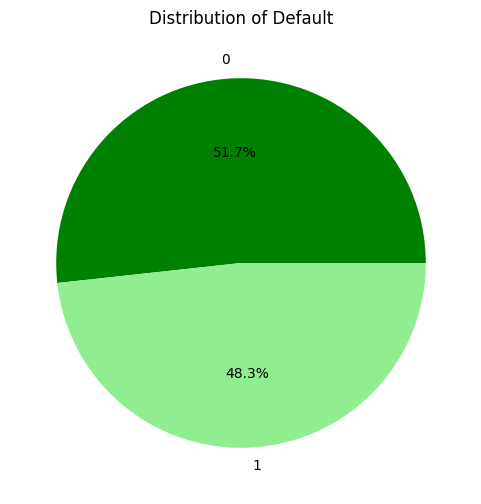

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
df['Status'].value_counts().plot.pie(autopct='%1.1f%%', colors=['green', 'lightgreen'])

plt.title('Distribution of Default')
plt.ylabel('')
plt.show()

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

le = LabelEncoder()
data_encode = df
data_encode['Home'] = le.fit_transform(df['Home'])
data_encode['Intent'] = le.fit_transform(df['Intent'])
data_encode['Default'] = le.fit_transform(df['Default'])
data_encode

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,22,59000,3,123.0,4,35000,16.02,1,0.59,1,3
1,25,9600,0,1.0,3,5500,12.87,1,0.57,0,3
2,23,65500,3,4.0,3,35000,15.23,1,0.53,0,2
3,24,54400,3,8.0,3,35000,14.27,1,0.55,1,4
4,21,9900,2,2.0,5,2500,7.14,1,0.25,0,2
...,...,...,...,...,...,...,...,...,...,...,...
12845,52,65004,3,4.0,4,20000,15.58,1,0.31,1,19
12846,52,64500,3,0.0,1,5000,11.26,0,0.08,0,20
12847,54,120000,0,4.0,4,17625,7.49,0,0.15,0,19
12848,65,76000,3,3.0,2,35000,10.99,1,0.46,0,28


In [4]:
X = data_encode.drop(columns=['Status'])
y = data_encode['Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define a Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, input_dim, d_model))
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.embedding(src) + self.pos_encoder
        output = self.transformer_encoder(src)
        output = self.fc_out(output.mean(dim=1))
        return output

# Define model hyperparameters
input_dim = X_train.shape[1]
d_model = 64
nhead = 8
num_encoder_layers = 3
dim_feedforward = 256
dropout = 0.1
lr = 0.005
epochs = 100

# Prepare data for PyTorch
train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
model = TransformerModel(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch.unsqueeze(1)).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch.unsqueeze(1)).squeeze()
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()
            predicted = torch.sigmoid(y_pred).round()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    test_loss /= len(test_loader)
    accuracy = correct / total

    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

# Evaluate model performance
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred_batch = model(X_batch.unsqueeze(1)).squeeze()
        y_pred.extend(torch.sigmoid(y_pred_batch).numpy())
        y_true.extend(y_batch.numpy())

# Convert predictions to binary
y_pred = [1 if pred >= 0.5 else 0 for pred in y_pred]


Epoch 1/100, Train Loss: 0.0857, Test Loss: 0.0825, Accuracy: 0.9751
Epoch 2/100, Train Loss: 0.0807, Test Loss: 0.0360, Accuracy: 0.9930
Epoch 3/100, Train Loss: 0.0920, Test Loss: 0.0962, Accuracy: 0.9685
Epoch 4/100, Train Loss: 0.0917, Test Loss: 0.0829, Accuracy: 0.9739
Epoch 5/100, Train Loss: 0.1615, Test Loss: 0.5188, Accuracy: 0.7829
Epoch 6/100, Train Loss: 0.5307, Test Loss: 0.5408, Accuracy: 0.7829
Epoch 7/100, Train Loss: 0.5362, Test Loss: 0.5233, Accuracy: 0.7829
Epoch 8/100, Train Loss: 0.5366, Test Loss: 0.5234, Accuracy: 0.7829
Epoch 9/100, Train Loss: 0.5357, Test Loss: 0.5294, Accuracy: 0.7829
Epoch 10/100, Train Loss: 0.5363, Test Loss: 0.5231, Accuracy: 0.7829
Epoch 11/100, Train Loss: 0.5356, Test Loss: 0.5231, Accuracy: 0.7829
Epoch 12/100, Train Loss: 0.5364, Test Loss: 0.5235, Accuracy: 0.7829
Epoch 13/100, Train Loss: 0.5368, Test Loss: 0.5231, Accuracy: 0.7829
Epoch 14/100, Train Loss: 0.5342, Test Loss: 0.5234, Accuracy: 0.7829
Epoch 15/100, Train Loss: 0.5

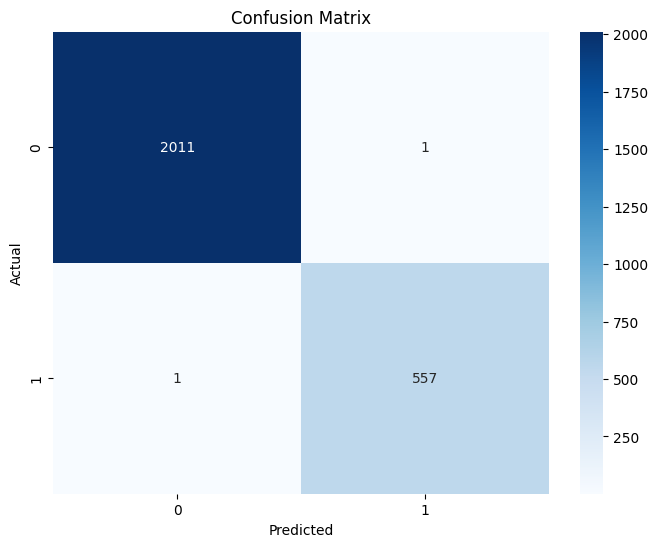

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [8]:
precision = 1830 / (1830 + 182)
print("Precison: ",precision)
recall = 1830 / (1830 + 1)
print("Recall: ", recall)

Precison:  0.9095427435387674
Recall:  0.9994538503549972
